In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LassoCV

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
FOLDS = 4
N_JOBS = 6
SEED = 2016

#DATA = "Base"
DATA = "Time"


In [2]:
# Get data
train = pd.read_csv("clean_data/train_" + DATA + ".csv")
y = pd.read_csv("clean_data/y.csv")

X_train = pd.read_csv("clean_data/X_train_" + DATA + ".csv")
y_train = pd.read_csv("clean_data/y_train.csv")

X_trainVal = pd.read_csv("clean_data/X_trainVal_" + DATA + ".csv")
y_trainVal = pd.read_csv("clean_data/y_trainVal.csv")

test = pd.read_csv("clean_data/test_" + DATA + ".csv")

X_test = pd.read_csv("clean_data/X_test_" + DATA + ".csv")
y_test = pd.read_csv("clean_data/y_test.csv")

X_testVal = pd.read_csv("clean_data/X_testVal_" + DATA + ".csv")
y_testVal = pd.read_csv("clean_data/y_testVal.csv")


In [3]:
# Definitions for Lasso

def run_lasso(X_train, y_train) :
    la = LassoCV(
        alphas = [0.001, 0.003, 0.006, 0.01, 0.03, 0.06], 
        n_jobs = N_JOBS, 
        random_state = SEED, 
        #tol = 0.0005,
        max_iter = 50000, 
        normalize  = True)
    la.fit(X_train, y_train)
    
    alpha = la.alpha_
    la = LassoCV(
        alphas = [alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                  alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3], 
        n_jobs = N_JOBS, 
        random_state = SEED, 
        #tol = 0.0005,
        max_iter = 50000, 
        normalize  = True)
    la.fit(X_train, y_train)
    print("LASSO Best alpha :", la.alpha_)
    print("LASSO iter :", la.n_iter_)

    return (la)

In [4]:
# Generate y_test predictions to be able to optimize ensemble weights
la = run_lasso(X_train, y_train.TARGET)
preds_y_test = la.predict(X_test) 

LASSO Best alpha : 0.0021
LASSO iter : 29


In [5]:
# Show MSE on y_test
print("Average Lasso MSE on held-out fold : " + str(mean_squared_error(y_test.TARGET, preds_y_test)))


Average Lasso MSE on held-out fold : 187.965520952


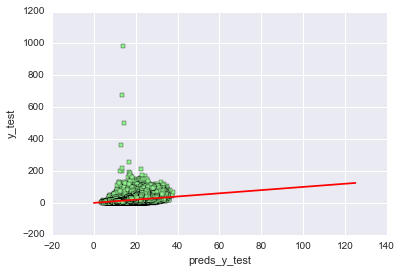

()

In [6]:
# Plot predictions
def plotPreds(preds, reals, xlbl, ylbl, dim) :
    plt.scatter(preds, reals, c = "lightgreen", marker = "s", label = "")
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.plot([0, dim], [0, dim], c = "red")
    plt.show()
    return()

plotPreds(preds_y_test, y_test.TARGET, "preds_y_test", "y_test", 125)


In [7]:
# Save held-out fold predictions
y_test_name = "y_test_preds/Lasso" + DATA + ".csv"
pd.DataFrame({"TARGET": preds_y_test}).to_csv(y_test_name, index = None, sep = ";")


In [8]:
# Now generate predictions on whole test set, to be used in ensemble for submissions
print("DATA : " + DATA)
la = run_lasso(train, y.TARGET)
preds_test = la.predict(test.drop(["ID"], axis = 1)) 


DATA : Time
LASSO Best alpha : 0.0009
LASSO iter : 130


In [9]:
# Correct predictions for negative outputs
preds_test[preds_test < 0] = 0

In [10]:
# Save test set predictions
testID = pd.read_csv("clean_data/testID.csv", header = None)
test_name = "test_preds/Lasso_" + DATA + ".csv"
pd.DataFrame({"ID": testID[0], "TARGET": preds_test}, columns = ["ID", "TARGET"]).to_csv(test_name, index = None, sep = ";")

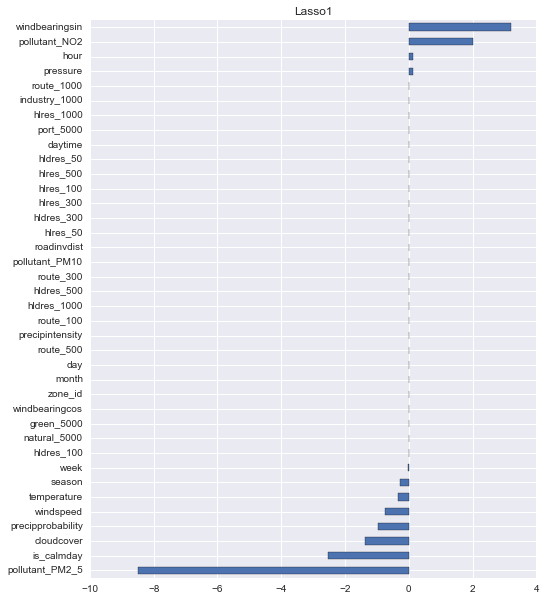

Lasso picked 19 features and eliminated the other 19 features


In [11]:
# Plot important coefficients
coefs = pd.Series(la.coef_, index = train.columns)
pd.concat([coefs.sort_values()]).plot(kind = "barh", figsize = (8, 10))
plt.title("Lasso1")
plt.show()
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " + str(sum(coefs == 0)) + " features")